In [472]:
%reset
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import sympy as sym
import numpy as np
from IPython.display import display
from sympy import pprint

import dill
dill.load_session('simplified_bipod_final_mark.db')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [473]:

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] + [BLD] + [foot_angle] + [foot_length] +\
           [cg] + [lx_boom] + [ly_boom] +\
           [y_boomOffset] + [y_bodyOffset] + [x_footOffset] +\
           [COMR[link,leg] for leg in legs for link in links]+\
           [masses[base] for base in bases] +\
           [masses[link,leg] for leg in legs for link in links] +\
           [lengths[base] for base in bases] +\
           [lengths[link,leg] for leg in legs for link in links] +\
           [inertias['body']] + [inertias['boom','X']] + [inertias['boom','Y']] +\
           [inertias[link,leg] for leg in legs for link in links] +\
           [x_body]+[y_body]+[th_body] + [th[link,leg] for leg in legs for link in links] +\
           [dx_body]+[dy_body]+[dth_body] + [dth[link,leg] for leg in legs for link in links] +\
           [ddx_body]+[ddy_body]+[ddth_body] + [ddth[link,leg] for leg in legs for link in links] +\
           [tau['left',leg] for leg in legs] + [tau['right',leg] for leg in legs] +\
           [lamda['x',leg] for leg in legs] + [lamda['y',leg] for leg in legs] +\
           [GRF['x',leg] for leg in legs] + [GRF['y',leg] for leg in legs]

lamb_EOMs = {}

DOFs = ['x_body'] + ['y_body'] +['theta_body']

for leg in legs:
    for link in links:
        DOFs = DOFs + ['theta_{0}'.format(link+leg)]

# for dof_i,dof in enumerate(DOFs):
#     print(dof_i)
#    1


        
# print(len(DOFs))
# print(len(EOMs))     
for dof_i,dof in enumerate(DOFs):
    lamb_EOMs.update({dof: sym.lambdify(sym_list,EOMs[dof_i],modules = [func_map])})
# print(EOMs[0])

In [474]:
# PARAMETERS:

COMR_ = {'ULA': 41.14/174.5,
         'LLA': 132.2/300,
         'URA': 41.14/174.5,
         'LRA': 190.4/295.5,
         'ULB': 41.14/174.5,
         'LLB': 132.2/300,
         'URB': 41.14/174.5,         
         'LRB': 190.4/295.5}

masses_ = {'body': 5756.78/1000,
           'boom': 2470.66/1000,
           'ULA': 153.81/1000,
           'LLA': 346.45/1000,
           'URA': 153.81/1000,
           'LRA': 499.95/1000,
           'ULB': 153.81/1000,
           'LLB': 346.45/1000,
           'URB': 153.81/1000,
           'LRB': 499.95/1000}

lengths_ = {'body': 253/1000,
            'boom': None,
            'ULA': 174.5/1000,
            'LLA': 300.0/1000,
            'URA': 174.5/1000,
            'LRA': 295.5/1000,
            'ULB': 174.5/1000,
            'LLB': 300.0/1000,
            'URB': 174.5/1000,
            'LRB': 295.5/1000}

''' ****** '''
inertias_ = {'body': 32124078.52*1e-9, # body rotate about its center 
             'boom_X': 1947254622.19*1e-9,
             'boom_Y': 1947254622.19*1e-9,
             'ULA': 600933.68*1e-9, # rotates as pendulumn
             'LLA': 4659658.63*1e-9,
             'URA': 600933.68*1e-9,
             'LRA': 7369968.50*1e-9,
             'ULB': 600933.68*1e-9, # rotates as pendulumn 
             'LLB': 4659658.63*1e-9,
             'URB': 600933.68*1e-9,
             'LRB': 7369968.50*1e-9}

all_links = []
all_links_inertia = []
leg_links = []
[leg_links.append(link+leg) for leg in legs for link in links]
[all_links.append(base) for base in bases]
[all_links.append(link+leg) for leg in legs for link in links]
all_links_inertia.append('body')
all_links_inertia.append('boom_X')
all_links_inertia.append('boom_Y')
[all_links_inertia.append(link+leg) for leg in legs for link in links]


total_mass = 0.0
for mass in masses_:
    total_mass += masses_[mass]
total_mass

WDOFs = ['X','Y'] 
signs = ['-ve','+ve'] 
ground_constraints = ['contact','friction','slip_+ve','slip_-ve'] # Group all constraints occuring at the ground
sides = ['left','right']
coordinates = {'X':0 , 'Y':1}
motor_w_angle = {'left': 'UL' ,'right': 'UR'}

def get_var_list_zeros(m,n):
    var_list = [m.g] + [m.BLD] + [m.foot_angle] + [m.foot_length] +\
               [m.cg] + [m.lx_boom] + [m.ly_boom] +\
               [m.y_boomOffset] + [m.y_bodyOffset] + [m.x_footOffset] +\
               [m.COMR[link+leg] for leg in legs for link in links]+\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias['body']] + [m.inertias['boom_X']] + [m.inertias['boom_Y']] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs]
    return var_list

def get_var_list_values(m,n):
    
    BW = 1
    tau_value = {}
    connection_force_value = {}
    GRF_X_value = {}
    GRF_Y_value = {}
    
    for leg in legs:
        
        [tau_value.update({(side,leg): BW*(m.tau_torque[n,side,leg])}) for side in sides]
        #[connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,'+ve',wdof,leg]-m.connect_force[n,'-ve',wdof,leg])}) for wdof in WDOFs]
        #[connection_force_value.update({(wdof,leg):0.0})for wdof in WDOFs]
        [connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,wdof,leg])}) for wdof in WDOFs]
        GRF_X_value.update({(leg):BW*(m.GRF_x[n,'+ve',leg]-m.GRF_x[n,'-ve',leg])})
        GRF_Y_value.update({(leg):BW*(m.GRF_y[n,leg])})

    var_list = [m.g] + [m.BLD] + [m.foot_angle] + [m.foot_length] +\
               [m.cg] + [m.lx_boom] + [m.ly_boom] +\
               [m.y_boomOffset] + [m.y_bodyOffset] + [m.x_footOffset] +\
               [m.COMR[link+leg] for leg in legs for link in links]+\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias['body']] + [m.inertias['boom_X']] + [m.inertias['boom_Y']] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [tau_value['left',leg] for leg in legs] + [tau_value['right',leg] for leg in legs] +\
               [connection_force_value['X',leg] for leg in legs] + [connection_force_value['Y',leg] for leg in legs] +\
               [GRF_X_value[leg] for leg in legs] + [GRF_Y_value[leg] for leg in legs]
    return var_list



--------------
Stall torque =  140.4238410596027
Max speed =  55.8
--------------


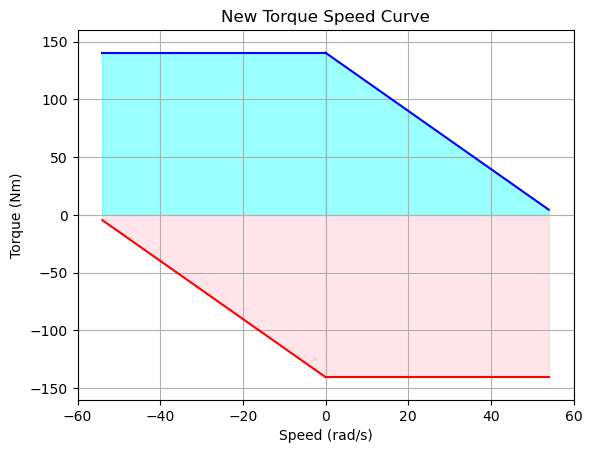

In [475]:
'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt
x_p = np.linspace(0, 54, num=54)
x_n = np.linspace(-54, 0, num=54)
no_load_speed = 55.8
# from graph
max_torque = 38.0
speed_max_torque = 40.7

m_grad = (max_torque-0.0)/(speed_max_torque-no_load_speed)

stall_torque = 0.0 - m_grad*no_load_speed

y_p = m_grad*x_p+stall_torque
y_n = m_grad*x_n-stall_torque

stall_torque_p = []
stall_torque_n = []
rated_torque_p = []
rated_torque_n = []

for ii in range(len(x_p)):
    stall_torque_p.append(stall_torque)
    stall_torque_n.append(-stall_torque)
    rated_torque_p.append(max_torque)
    rated_torque_n.append(-max_torque)

plt.grid()
plt.plot(x_p, y_p,'b')
plt.plot(x_n, stall_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, stall_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

plt.axis((-60,60,-160,160))
plt.title('New Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
print('--------------')

print('Stall torque = ',stall_torque)
print('Max speed = ',no_load_speed)

print('--------------')

In [476]:
tests = {0:'High_Drop', 1:'Low_Drop', 2:'Hop',3:'Drop_Hop', 4:'Sprint', 5:'Start_Periodic_Walk',\
         6:'Periodic_Walk', 7:'Periodic_Walk_Stop'}

test = tests[6]
#V_avg = 0.5
mu_value = 1
# V_avg = 0.8

body_height = 0.38
stride_length = 0.4
speed_factor = 0.4
V_avg = speed_factor*sqrt(body_height*9.81)




if test == 'High_Drop' or test == 'Low_Drop':
    N = 50
    TT = 0.2
elif test == 'Hop' or test == 'Drop_Hop':
    N = 50
    TT = 1.0
elif test == 'Sprint':
    N = 100
    TT = 1.5
    x_final = 5.0
elif test == 'Start_Periodic_Walk':
    N = 70
    TT = 0.5*(stride_length/V_avg)
    
    #TT = 0.1,  pen = 132
    #TT = 0.15, pen = 52,8
    #TT = 0.17, pen = 43.47
    #TT = 0.17, pen = 20.46
    #TT = 0.19, pen = 22.86
    #TT = 0.195,pen = 44.55
    #TT = 0.20, pen = 21.52
    #TT = 0.201,pen = 44.76
    #TT = 0.202,pen = 21.417
    #TT = 0.205,pen = 21.85
    #TT = 0.21, pen = 21.96
#     xfinal/V_avg = TT
elif test == 'Periodic_Walk':
    N = 50
    x_final = stride_length
    TT = x_final/V_avg
elif test =='Periodic_Walk_Stop':
    N = 50
    TT = 0.3
else:
    pass

In [477]:
m = ConcreteModel('Biped')

#SETS-------------------------
m.N = RangeSet(N)
m.ground_constraints = Set(initialize = ground_constraints)
m.legs = Set(initialize = legs)
m.links = Set(initialize = links)
m.bases = Set(initialize = bases)
m.all_links = Set(initialize = all_links)
m.leg_links = Set(initialize = leg_links)
m.all_links_inertia = Set(initialize = all_links_inertia)
m.DOFs = Set(initialize = DOFs)
m.WDOFs = Set(initialize = WDOFs)
m.signs = Set(initialize = signs)
m.sides = Set(initialize = sides)

#Params--------------------------
m.g = Param(initialize = 9.81)
m.BLD = Param(initialize = 60/1000)
m.foot_angle = Param(initialize = 135*(np.pi/180))
m.foot_length = Param(initialize = 42.5/1000)
m.cg = Param(initialize = 1.149)
m.lx_boom = Param(initialize = 2.575)
m.ly_boom = Param(initialize = 2.493)
m.y_boomOffset = Param(initialize = 0.101)
m.y_bodyOffset = Param(initialize = 8.36/1000)
m.x_footOffset = Param(initialize = 1.63/1000)

m.COMR = Param(m.leg_links, initialize = COMR_)
m.masses = Param(m.all_links, initialize = masses_)
m.lengths = Param(m.all_links, initialize = lengths_)
m.inertias = Param(m.all_links_inertia, initialize = inertias_)


#VARIABLES----------------------
#gen coordinates
m.q = Var(m.N,m.DOFs)
m.dq = Var(m.N,m.DOFs)
m.ddq = Var(m.N,m.DOFs)

''' CONSTRAINTS  - Integration'''
# variable timestep
hm = TT/N # master timestep
m.h = Var(m.N, bounds = (0.8,1.2)) #m.h = Var(m.N, bounds = (0.5,1.5))

def BwEuler_p(m,n,dof):
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOFs, rule = BwEuler_p)

def BwEuler_v(m,n,dof):
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOFs, rule = BwEuler_v)

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lengths) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/mark/miniconda3/lib/python3.9/site-
    packages/pyomo/core/base/param.py:77)


In [478]:
''' CONSTRAINTS  - CONNECTION POINT'''
m.connect_position = Var(m.N, m.WDOFs, m.sides, m.legs) # connection point
m.connect_force = Var(m.N, m.WDOFs, m.legs,bounds = (-10*total_mass*9.81,10*total_mass*9.81)) # connection force

# Lamdify
lamb_connect_position = {} # (WDOFs,sides,leg)
[lamb_connect_position.update({(wdof,side,leg): sym.lambdify(sym_list,connect_position[side,leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for side in sides for wdof in WDOFs]

# Equate the connection equations from the previous script to the model m
def def_connect_position_equation(m,n,wdof,side,leg):
    var_list = get_var_list_zeros(m,n)    
    return m.connect_position[n,wdof,side,leg] == lamb_connect_position[wdof,side,leg](*var_list)
m.connect_position_equation = Constraint(m.N, m.WDOFs, m.sides, m.legs, rule = def_connect_position_equation)

# Ensure that there is no distance between the X (and Y) of link connection points
def def_connect_position(m,n,wdof,leg):
    return  m.connect_position[n,wdof,'right',leg] - m.connect_position[n,wdof,'left',leg] == 0.0
m.connect_position_constraint = Constraint(m.N, m.WDOFs, m.legs, rule= def_connect_position)

In [479]:
#Variable of foot position
m.foot_position = Var(m.N, m.WDOFs, m.legs)
for n in range(1,N+1):
    for leg in legs:
        m.foot_position[n,'Y',leg].setlb(0.0)

#Get the foot position in WDOF
lamb_foot_position = {}
[lamb_foot_position.update({(wdof,leg): sym.lambdify(sym_list,foot_position['right',leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for wdof in WDOFs]

def def_foot_position(m,n,wdof,leg):
    var_list = get_var_list_zeros(m,n)
    return m.foot_position[n,wdof,leg] == lamb_foot_position[wdof,leg](*var_list)
m.def_foot_position = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_position)

m.mu = Param(initialize = mu_value,within=Any)

# Variables
m.foot_velocity = Var(m.N, m.WDOFs, m.signs, m.legs, bounds = (0.0,None)) # the sign will account for -ve velocities
m.friction_cone = Var(m.N, m.legs, bounds = (0.0,None)) 
m.GRF_y = Var(m.N, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces
m.GRF_x = Var(m.N, m.signs, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces

'''******'''
m.ground_penalty = Var(m.N, m.ground_constraints, m.legs, bounds = (0.0,10.0)) # penalty

lamb_foot_velocity_x = {}

# Get the foot position in WDOF
[lamb_foot_velocity_x.update({(leg): sym.lambdify(sym_list,(foot_position['right',leg].jacobian(q)*dq)[0].simplify(),modules = [func_map])}) for leg in legs]

# CONSTRAINTS
def def_foot_velocity(m,n,wdof,leg):
    if wdof == 'X':
        var_list = get_var_list_zeros(m,n)
        return m.foot_velocity[n,'X','+ve',leg]-m.foot_velocity[n,'X','-ve',leg] == lamb_foot_velocity_x[leg](*var_list)
    else: return Constraint.Skip
m.foot_velocity_constraint = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_velocity)

def def_friction_cone(m,n,leg):
    return m.friction_cone[n,leg] == m.mu*m.GRF_y[n,leg] - (m.GRF_x[n,'+ve',leg] + m.GRF_x[n,'-ve',leg])
m.friction_cone_constraint = Constraint(m.N, m.legs, rule = def_friction_cone)

# constraints: complementarity

# contact
def def_ground_contact(m,n,leg):
    if n < N:
        return m.foot_position[n+1,'Y',leg]*m.GRF_y[n,leg] <= m.ground_penalty[n,'contact',leg]
    else:
        return Constraint.Skip
m.ground_contact_constraint = Constraint(m.N, m.legs, rule = def_ground_contact)

# friction
def def_ground_friction(m,n,leg):
    return (m.foot_velocity[n,'X','+ve',leg]+m.foot_velocity[n,'X','-ve',leg])*m.friction_cone[n,leg] <= m.ground_penalty[n,'friction',leg]
m.ground_friction_constraint = Constraint(m.N, m.legs, rule = def_ground_friction)

# slipping
def def_ground_slip_positive(m,n,leg):
    return m.foot_velocity[n,'X','+ve',leg]*m.GRF_x[n,'+ve',leg] <= m.ground_penalty[n,'slip_+ve',leg]
m.ground_slip_positive_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_positive)

def def_ground_slip_negative(m,n,leg):
    return m.foot_velocity[n,'X','-ve',leg]*m.GRF_x[n,'-ve',leg] <= m.ground_penalty[n,'slip_-ve',leg]
m.ground_slip_negative_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_negative)

#bound contact forces at last node
for leg in legs:
    m.GRF_y[N,leg].fix(0.0)
    for sgn in signs:
        m.GRF_x[N,sgn,leg].fix(0.0)


In [480]:
'''Torque Speed - Speed Torque Curve'''

m.tau_torque = Var(m.N, m.sides, m.legs, bounds = (-max_torque,max_torque))
m.tau_velocity = Var(m.N, m.sides, m.legs, bounds = (-no_load_speed,no_load_speed))

lamb_tau_velocity = {}
[lamb_tau_velocity.update({(side,leg): sym.lambdify(sym_list,w_links[motor_w_angle[side],leg],modules = [func_map])}) for leg in legs for side in sides]

def def_angular_velocity(m,n,side,leg):
    var_list = get_var_list_zeros(m,n)
    return m.tau_velocity[n,side,leg] == lamb_tau_velocity[side,leg](*var_list)
m.left_angular_velocity_constraint = Constraint(m.N, m.sides, m.legs, rule = def_angular_velocity)

# assume straight line
def def_TW_right(m,n,side,leg):
    return m.tau_torque[n,side,leg] <= m.tau_velocity[n,side,leg]*m_grad + stall_torque
m.TW_right_constraint = Constraint(m.N, m.sides, m.legs, rule = def_TW_right)

def def_TW_left(m,n,side,leg):
    return m.tau_torque[n,side,leg] >= m.tau_velocity[n,side,leg]*m_grad - stall_torque
m.TW_left_constraint = Constraint(m.N, m.sides, m.legs, rule = def_TW_left)

In [481]:
# Set the angles for the knees - only use this when actuated 
# This ensures links does not cross
m.knee_angle = Var(m.N, m.sides, m.legs, bounds = (0.0,150*(np.pi)/180))

def def_knee_angle(m,n,side,leg):
    if side == 'left':
        return m.knee_angle[n,side,leg] == 2*np.pi - m.q[n,'theta_LL'+leg]
    else:
        return m.knee_angle[n,side,leg] == m.q[n,'theta_LR'+leg]   
m.knee_angle_constraint = Constraint(m.N, m.sides, m.legs, rule = def_knee_angle)

In [482]:
# Get the foot position in WDOF
if test == "Periodic_Walk" or test == "Periodic_Hop":
    
    lamb_body_position_x = sym.lambdify(sym_list,(r_bases['body'])[0].simplify(),modules = [func_map])
    m.body_position = Var(m.N, m.WDOFs) # the sign will account for -ve velocities

    # CONSTRAINTS
    def def_body_position(m,n,wdof):
        var_list = get_var_list_zeros(m,n)
        if wdof == 'X':
            return m.body_position[n,'X'] == lamb_body_position_x(*var_list)
        else: return Constraint.Skip
    m.body_position_constraint = Constraint(m.N, m.WDOFs, rule = def_body_position)
    
    
    if test == "Periodic_Walk":
        
#         def def_hold_foot(m,n):
#             return m.foot_position[1,'X','B'] - m.foot_position[N,'X','B'] == 0
#         m.def_hold_foot_constraint = Constraint(m.N, rule = def_hold_foot)
        
        # Average velocities
        def def_body_position_average(m,wdof):
            if wdof == 'X':
                return (m.body_position[N,'X'] - m.body_position[1,'X'])/(sum(hm*m.h[n] for n in range(1,N+1))) == V_avg
            else: return Constraint.Skip
        m.def_body_position_average_constraint = Constraint(m.WDOFs, rule = def_body_position_average)
        
        # Equate states
        def def_equate_position_states(m,n,dof_i):
            
            if dof_i == 'y_body':# or dof_i == 'theta_body':
                return m.q[1,dof_i] == m.q[N,dof_i]
            
            elif dof_i == 'theta_ULA':
                return m.q[1,'theta_ULA'] == m.q[N,'theta_ULB']
            elif dof_i == 'theta_ULB':
                return m.q[1,'theta_ULB'] == m.q[N,'theta_ULA']
            
            elif dof_i == 'theta_URA':
                return m.q[1,'theta_URA'] == m.q[N,'theta_URB']
            elif dof_i == 'theta_URB':
                return m.q[1,'theta_URB'] == m.q[N,'theta_URA']
            
            elif dof_i == 'theta_LLA':
                return m.q[1,'theta_LLA'] == m.q[N,'theta_LLB']
            elif dof_i == 'theta_LLB':
                return m.q[1,'theta_LLB'] == m.q[N,'theta_LLA']
            
            elif dof_i == 'theta_LRA':
                return m.q[1,'theta_LRA'] == m.q[N,'theta_LRB']

#             elif dof_i == 'theta_ULA':
#                 return m.q[1,'theta_ULA'] == m.q[N,'theta_ULA']
#             elif dof_i == 'theta_ULB':
#                 return m.q[1,'theta_ULB'] == m.q[N,'theta_ULB']
            
#             elif dof_i == 'theta_URA':
#                 return m.q[1,'theta_URA'] == m.q[N,'theta_URA']
#             elif dof_i == 'theta_URB':
#                 return m.q[1,'theta_URB'] == m.q[N,'theta_URB']
            
#             elif dof_i == 'theta_LLA':
#                 return m.q[1,'theta_LLA'] == m.q[N,'theta_LLA']
#             elif dof_i == 'theta_LLB':
#                 return m.q[1,'theta_LLB'] == m.q[N,'theta_LLB']
            
#             elif dof_i == 'theta_LRA':
#                 return m.q[1,'theta_LRA'] == m.q[N,'theta_LRA']
            
#             elif dof_i == 'theta_LRB':
#                 return m.q[1,'theta_LRB'] == m.q[N,'theta_LRB']
            else: 
                 return Constraint.Skip
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs, rule = def_equate_position_states) 

        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)
  
    
        # Condition where the GRF can't increase twice from zero          
    
    
    else: 
        
        def def_equate_position_states(m,n,dof_i):
            return m.q[1,dof_i] == m.q[N,dof_i]
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states)
        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)

else: pass
                                    


In [483]:
#test code

sign_symbols = ['+','-']
boundaries = ['setub','setlb']

for n in range(1,N+1):
    for leg in legs:
        for index in range(len(boundaries)):
            eval('m.q[n,\'theta_UL\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))
            eval('m.q[n,\'theta_LL\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))  
            eval('m.q[n,\'theta_UR\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))    
            eval('m.q[n,\'theta_LR\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))

    m.q[n,'theta_body'].setub(np.pi*(1/6))
    m.q[n,'theta_body'].setlb(np.pi*(-1/6))
    
    if test == 'High_Drop' or test == 'Low_Drop' or test == 'Drop_Hop' or test == 'Hop':
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = -0.5
        y_high_lim = 2.0
        
        if test == 'Drop_Hop' or test == 'Hop':
            [m.tau_torque[1,side,leg].fix(0.0) for side in sides for leg in legs]
        else:
            [m.tau_torque[n,side,leg].fix(0.0) for side in sides for leg in legs]
            
    else:
        x_low_lim = -1.0
        x_high_lim = 2.0
        y_low_lim = -0.5
        y_high_lim = 1.5
        
        if test == 'Sprint' or test == 'Periodic_Walk' or test == 'Periodic_Walk_Stop' or test == 'Start_Periodic_Walk':
            pass
        else:
            [m.tau_torque[1,side,leg].fix(0.0) for side in sides for leg in legs]
            
        

In [484]:
if test == 'High_Drop':
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))

    m.q[1,'theta_ULA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_URA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ULB'].fix(np.pi*(0.5-1/10))
    m.q[1,'theta_URB'].fix(np.pi*(0.5+1/10))
    
elif test == 'Low_Drop':
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))

    m.q[1,'theta_ULA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_URA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ULB'].fix(np.pi*(0.5-1/10))
    m.q[1,'theta_URB'].fix(np.pi*(0.5+1/10))
    
elif test == 'Hop':
    m.q[1,'y_body'].fix(0.35)
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
    m.foot_position[1, 'X', 'A'].fix(0.0)
    m.foot_position[1, 'X', 'B'].fix(0.0)
        
    m.q[N,'y_body'].setlb(0.8)
    
elif test == 'Drop_Hop':
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    
#     m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
#     m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

#     m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/7))
#     m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/7))
        
    m.foot_position[round(N/5), 'Y', 'A'].setub(0.05)
    m.foot_position[round(N/5), 'Y', 'B'].setub(0.05)
        
    m.q[N,'y_body'].setlb(0.8)
    m.q[N,'x_body'].setub(0.7)
    m.q[N,'x_body'].setlb(0.3)
    
elif test == 'Sprint':
    guide = np.linspace(0,x_final,N)
    for n in range(1,N+1):
        m.GRF_y[n,'A'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','A'].value = m.mu.value*m.GRF_y[n,'A'].value
        m.GRF_y[n,'B'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','B'].value = m.mu.value*m.GRF_y[n,'B'].value
        
        m.q[n,'y_body'].setub(0.6)
        m.q[n,'x_body'].setlb(0.0)
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    
    
    m.q[1,'theta_ULA'].fix(np.pi*(0.5))
    m.q[1,'theta_URA'].fix(np.pi*(0.5))
    m.q[1,'theta_ULB'].fix(np.pi*(0.5))
    m.q[1,'theta_URB'].fix(np.pi*(0.5))
        
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)

    # final condition
    m.q[N,'x_body'].setlb(x_final)

    m.dq[N,'x_body'].fix(0.0)
    m.dq[N,'theta_body'].fix(0.0)
    
    m.dq[N,'theta_ULA'].fix(0.0)
    m.dq[N,'theta_URA'].fix(0.0)
    m.dq[N,'theta_ULB'].fix(0.0)
    m.dq[N,'theta_URB'].fix(0.0)

    m.q[N,'theta_body'].fix(0.0)

    m.foot_position[N, 'Y', 'A'].fix(0.0)
    m.foot_position[N, 'Y', 'B'].fix(0.0)
    
    
elif test == 'Start_Periodic_Walk':
    #init conditions
    #match mid walk node1 conditions
    with open('periodic_walk_mid_v1.pkl','rb') as f:
        start_data = pickle.load(f)
    
    m.q[N,'y_body'].fix(start_data['ybod'])
    m.dq[N,'y_body'].fix(start_data['dybod'])
    m.dq[N,'x_body'].fix(start_data['dxbod'])
    
    m.dq[N,'theta_ULA'].fix(start_data['dthULA'])
    m.dq[N,'theta_LLA'].fix(start_data['dthLLA'])
    m.dq[N,'theta_URA'].fix(start_data['dthURA'])
    m.dq[N,'theta_LRA'].fix(start_data['dthLRA'])
    
    m.dq[N,'theta_ULB'].fix(start_data['dthULB'])
    m.dq[N,'theta_LLB'].fix(start_data['dthLLB'])
    m.dq[N,'theta_URB'].fix(start_data['dthURB'])
    m.dq[N,'theta_LRB'].fix(start_data['dthLRB'])
    
    xbod_init = 0.0
    xbod_final = stride_length/2
    
    xfoota_final = xbod_final + (stride_length/2)
    xfootb_final = xbod_final - (stride_length/2) #feet apart stance for periodic walk
    
    m.q[1,'x_body'].fix(xbod_init)
    #m.q[1,'y_body'].fix(body_height)
#     m.q[1,'theta_body'].fix(0.0)
    
    m.foot_position[1,'X','A'].fix(0.0)
    m.foot_position[1,'X','B'].fix(0.0)
    m.foot_position[1,'Y','A'].fix(0.0)
    m.foot_position[1,'Y','B'].fix(0.0)
#     m.GRF_y[1,'B'].fix(0.0)
    
    for n in range(1,N+1):
#         m.foot_position[n,'X','B'].fix(0.0)
#         m.foot_position[n,'Y','B'].fix(0.0)
#         m.foot_position[n,'X','A'].setlb(0.0)
        m.q[n,'theta_body'].fix(0.0)
#         m.GRF_y[n,'A'].fix(0.0)
    
    #final conditions
    
#     m.foot_position[N,'X','A'].fix(stride_length)
#     m.foot_position[N,'X','B'].fix(0.0)
#     m.foot_position[N,'Y','A'].fix(0.0)
#     m.foot_position[N,'Y','B'].fix(0.0)
    #set final position and velocity to N=1 of periodic walk
    
    m.q[N,'x_body'].fix(xbod_final)
#     m.q[N,'y_body'].fix(body_height)
#     m.q[N,'theta_body'].fix(0.0)
    
#     m.dq[N,'x_body'].fix(V_avg)
#     m.dq[N,'y_body'].fix(0.0)
#     m.dq[N,'theta_body'].fix(0.0)
    
elif test == 'Periodic_Walk':
    guide = np.linspace(0,TT*V_avg,N)
    
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1]
        m.q[n,'theta_body'].fix(0.0)
#         m.q[n,'y_body'].setub(0.42)
#         m.foot_position[n,'X','B'].fix(0.297)
    
#     m.foot_position[1,'Y','A'].fix(0.05)
    m.foot_position[1,'Y','B'].fix(0.0)
    
#     m.foot_position[1,'X','A'].fix(0.0)
#     m.foot_position[1,'X','B'].fix(0.0)
    
    m.q[1,'x_body'].fix(0.0)
#     m.dq[1,'y_body'].fix(0.0)

#     m.q[1,'theta_ULA'].setub(np.pi*(0.5-1/7))
#     m.q[1,'theta_URA'].setub(np.pi*(0.5-1/7))
    
#     m.q[1,'theta_ULB'].setlb(np.pi*(0.5+1/7))
#     m.q[1,'theta_URB'].setlb(np.pi*(0.5+1/7))
    
    m.foot_position[N/2,'Y','A'].fix(0.0)
    m.foot_position[N/2,'Y','B'].fix(0.0)
    
    for n in range(1,N+1):
        if n<(N/2):
            m.GRF_y[n,'A'].fix(0.0)
#             if n<(N/2 - 3):
#                 m.foot_position[n,'Y','A'].setlb(0.02)
        elif n>(N/2):
            m.GRF_y[n,'B'].fix(0.0)
#             if n>(N/2 + 3):
#                 m.foot_position[n,'Y','B'].setlb(0.02)
        else:
            pass
#         m.GRF_y[n,'A'].fix(0.0)
#         m.GRF_y[n,'B'].setlb(1)
#         if n<=3 or n>=N-3:
#             pass
#         else:
#             m.foot_position[n,'Y','A'].setlb(0.02)
            
    m.foot_position[N,'Y','A'].fix(0.0)
    
#     m.foot_position[N,'X','A'].fix(0.0)
#     m.foot_position[N,'X','B'].fix(0.0)
#     m.foot_position[N,'Y','B'].fix(0.05)
    
#     m.foot_position[1,'X','B'] == m.foot_position[N,'X','B']
    

    
elif test == 'Periodic_Walk_Stop':
    
    with open('periodic_walk_mid_v1.pkl','rb') as f:
        start_data = pickle.load(f)
    
    m.q[1,'y_body'].fix(start_data['ybod'])
    m.dq[1,'x_body'].fix(start_data['dxbod'])
    
    m.dq[1,'theta_ULA'].fix(start_data['dthULA'])
    m.dq[1,'theta_LLA'].fix(start_data['dthLLA'])
    m.dq[1,'theta_URA'].fix(start_data['dthURA'])
    m.dq[1,'theta_LRA'].fix(start_data['dthLRA'])
    
    m.dq[1,'theta_ULB'].fix(start_data['dthULB'])
    m.dq[1,'theta_LLB'].fix(start_data['dthLLB'])
    m.dq[1,'theta_URB'].fix(start_data['dthURB'])
    m.dq[1,'theta_LRB'].fix(start_data['dthLRB'])
    
    m.q[1,'x_body'].fix(0.0) # initial condition
    m.q[1,'theta_body'].fix(0.0)
#     m.q[1,'y_body'].fix(body_height)
    
#     m.dq[1,'theta_body'].fix(0)
#     m.dq[1,'y_body'].fix(0.0)

    m.foot_position[1,'X','A'].fix(0.0-(stride_length/2))
    m.foot_position[1,'X','B'].fix(0.0+(stride_length/2))
    m.foot_position[1,'Y','A'].fix(0.0)
    m.foot_position[1,'Y','B'].fix(0.0)
#     m.q[1,'y_body'].fix(body_height)
    
    for n in range(1,N+1):
        m.foot_position[n,'X','B'].fix(stride_length/2)
        m.foot_position[n,'Y','B'].fix(0.0)
    
    for n5 in range(N-5,N+1): # last 5 nodes 
        for dof_i in DOFs:
            if dof_i == 'x_body':
                m.dq[n5,dof_i].setub(0.0)
            else:
                pass
#                 m.dq[n5,dof_i].setub(0.05*m.dq[1,dof_i])
                
        m.foot_position[n5, 'Y', 'A'].fix(0.0)
        m.foot_position[n5, 'Y', 'B'].fix(0.0)
        
    m.q[N,'x_body'].fix(stride_length/2)
#     m.q[N,'y_body'].fix(body_height)
    m.q[N,'theta_body'].fix(0.0)
    
    m.dq[N,'x_body'].fix(0.0)
    m.dq[N,'y_body'].fix(0.0)
    m.dq[N,'theta_body'].fix(0.0)
    
    m.dq[N,'theta_ULA'].fix(0.0)
    m.dq[N,'theta_URA'].fix(0.0)
    m.dq[N,'theta_LLA'].fix(0.0)
    m.dq[N,'theta_LRA'].fix(0.0)
    
    m.dq[N,'theta_ULB'].fix(0.0)
    m.dq[N,'theta_URB'].fix(0.0)
    m.dq[N,'theta_LLB'].fix(0.0)
    m.dq[N,'theta_LRB'].fix(0.0)
    
    
    
    m.foot_position[N,'X','A'].fix(stride_length/2)
    m.foot_position[N,'X','B'].fix(stride_length/2)
    
    
    
#     m.foot_position[N,'X','A'].fix(0.75)
#     m.foot_position[N,'X','B'].fix(0.25)
    
else:
    pass
        
    

In [485]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------
def CostFun(m):
    row = 1e6 # scale the penalty
    tau_sum = 0.0
    pen_sum = 0.0
    transport_sum = 0.0
   
    
    T = sum(m.h[n] for n in range(1,N+1))
    
    for n in range(1,N+1):
        for leg in legs:
            for side in sides:
                tau_sum += (m.tau_torque[n,side,leg])**2
                
            for gc in ground_constraints:
                for leg in legs:
                    pen_sum += m.ground_penalty[n,gc,leg] 
                    
    #return T + row*pen_sum + tau_sum
    return pen_sum   
m.Cost = Objective(rule = CostFun)

In [486]:
''' Turning EOM back to pyomo (from sympy) '''
#create the constraints
def EOM_x_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['x_body'](*var_list) == 0
m.EOM_x_body_constraint = Constraint(m.N, rule = EOM_x_body)

def EOM_y_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['y_body'](*var_list) == 0
m.EOM_y_body_constraint = Constraint(m.N, rule = EOM_y_body)

def EOM_th_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_body'](*var_list) == 0
m.EOM_th_body_constraint = Constraint(m.N, rule = EOM_th_body)

def EOM_th_ULA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ULA'](*var_list) == 0
m.EOM_th_ULA_constraint = Constraint(m.N, rule = EOM_th_ULA)

def EOM_th_LLA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_LLA'](*var_list) == 0
m.EOM_th_LLA_constraint = Constraint(m.N, rule = EOM_th_LLA)

def EOM_th_URA(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_URA'](*var_list) == 0
m.EOM_th_URA_constraint = Constraint(m.N, rule = EOM_th_URA)

def EOM_th_LRA(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_LRA'](*var_list) == 0
m.EOM_th_LRA_constraint = Constraint(m.N, rule = EOM_th_LRA)

def EOM_th_ULB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ULB'](*var_list) == 0
m.EOM_th_ULB_constraint = Constraint(m.N, rule = EOM_th_ULB)

def EOM_th_LLB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_LLB'](*var_list) == 0
m.EOM_th_LLB_constraint = Constraint(m.N, rule = EOM_th_LLB)

def EOM_th_URB(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_URB'](*var_list) == 0
m.EOM_th_URB_constraint = Constraint(m.N, rule = EOM_th_URB)

def EOM_th_LRB(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_LRB'](*var_list) == 0
m.EOM_th_LRB_constraint = Constraint(m.N, rule = EOM_th_LRB)

In [487]:
# solving
#opt = SolverFactory('ipopt',executable = '/home/uct/Trajectory_Optimization/IPOPT/build/bin/ipopt')
opt = SolverFactory('ipopt')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000*10   # maximum number of iterations
opt.options["max_cpu_time"] = 600*10 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

results = opt.solve(m, tee = True)

# model.piston_complementarity.deactivate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False).solve(model, tee=True)
# if result.solver.termination_condition != TerminationCondition.optimal: quit()
# # solve for discrete piston control3
# model.piston_complementarity.activate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False, warm_start=True).solve(model, tee=True)

Ipopt 3.14.10: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=300000
max_cpu_time=6000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.10, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    21482
Number of nonzeros in inequality constraint Jacobian.:     1986
Number of nonzeros in Lagrangian Hessian.............:    12251

Total number of variables............................:     4041
                     variables with only lower bounds:      396
                variables with lower and upper bounds:     1896
                     variables with only

 117r 8.5883667e+02 8.33e-01 5.54e+01  -1.7 1.44e+00    -  6.29e-01 4.94e-01f  1
 118r 8.0100305e+02 7.32e-01 8.05e+01  -1.7 1.07e+02    -  1.12e-01 5.93e-02f  1
 119r 7.8638407e+02 6.15e-01 1.25e+02  -1.7 4.71e+01    -  3.20e-01 1.67e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120r 7.4990851e+02 1.44e+00 2.94e+02  -1.7 7.48e+01    -  1.19e-02 4.53e-01f  1
 121r 7.4990930e+02 1.42e+00 9.71e+01  -1.7 3.13e+01  -0.7 3.29e-02 1.16e-02f  1
 122r 7.4921979e+02 1.41e+00 1.93e+02  -1.7 3.30e+01    -  3.61e-01 1.28e-02f  1
 123r 7.2550227e+02 6.06e-01 5.22e+01  -1.7 2.72e+01    -  2.63e-01 5.03e-01f  1
 124r 7.1448252e+02 2.98e-01 2.42e+02  -1.7 1.33e+01    -  1.44e-01 9.33e-01f  1
 125r 7.1474257e+02 2.94e-01 5.07e+01  -1.7 1.20e+00    -  8.04e-01 8.31e-01f  1
 126r 7.0049354e+02 2.92e-01 8.01e-03  -1.7 3.77e-01    -  1.00e+00 1.00e+00f  1
 127r 5.7514675e+02 2.68e-01 7.32e+01  -3.7 7.62e-01    -  5.13e-01 6.82e-01f  1
 128r 4.3897127e+02 2.50e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  8.4787514e-03 1.42e-03 8.12e+01  -5.7 1.09e+01  -4.3 2.11e-01 1.24e-01h  1
 211  4.0384487e-03 4.87e-02 5.20e+01  -5.7 5.90e+00  -3.9 9.23e-02 8.33e-01f  1
 212  2.4988447e-03 4.05e-02 5.13e+01  -5.7 1.32e+00  -3.5 7.04e-01 1.69e-01h  1
 213  1.5033493e-03 3.86e-02 4.85e+01  -5.7 5.18e+00  -3.9 5.70e-02 4.81e-02h  1
 214  2.0382096e-03 5.62e-03 1.47e+02  -5.7 1.56e+00  -4.4 1.10e-01 1.00e+00h  1
 215  1.5103506e-03 4.98e-03 5.97e+01  -5.7 1.22e+00  -4.9 8.99e-01 1.16e-01h  1
 216  1.5106310e-03 4.62e-03 1.14e+02  -5.7 2.60e-01  -5.4 3.38e-01 7.19e-02h  1
 217  1.5121748e-03 9.12e-04 3.91e-01  -5.7 3.99e-01  -5.8 9.97e-01 1.00e+00f  1
 218  1.5112697e-03 1.01e-03 3.48e+00  -5.7 2.19e+00  -6.3 1.00e+00 9.78e-01H  1
 219  1.5110357e-03 1.79e-03 1.01e-02  -5.7 1.07e+00  -6.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  1.5103788e-03 5.90e-04

In [488]:
print(results.solver.termination_condition) # check if optimal

optimal


In [489]:
# PLOT COST FUNCTION -------------------------------------------------------------------------------------------------------------
# T = sum(m.h[n] for n in range(1,N+1))
pen_sum = 0.0
for n in range(1,N+1):
        for gc in ground_constraints:
            for leg in legs:
                pen_sum += m.ground_penalty[n,gc,leg].value
print(pen_sum)

1.904745001771079e-05


In [490]:
# tau_sum = 0.0
# for n in range(1,N+1):
#     for leg in legs:
#         for side in sides:
#             tau_sum += (m.tau_torque[n,side,leg])**2
# print(tau_sum)

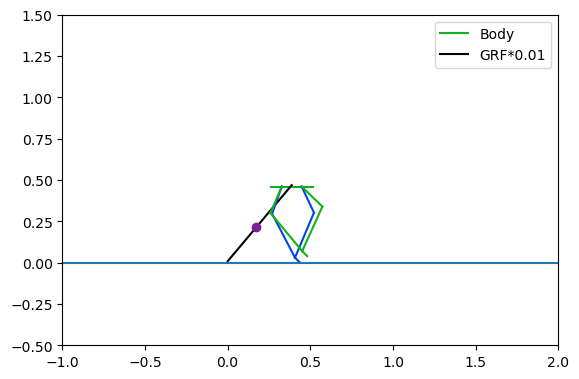

In [491]:
#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

# arrays to store values
N_time = []

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([x_low_lim,x_high_lim])
    ax.set_ylim([y_low_lim,y_high_lim])
    N_time.append(i)
     
    plot_body = {}
    plot_boom = {}
    plot_boom_COM = {}
    plot_UR = {}
    plot_LR = {}
    plot_UL = {}
    plot_LL = {}
    plot_foot = {}
    abs_angles = {}
    
    # plot body
    plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_back'):m.q[i,'y_body'].value - m.y_bodyOffset.value - 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})
    plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_front'):m.q[i,'y_body'].value - m.y_bodyOffset.value + 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})  
    ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:green')
    
    # plot boom
    plot_boom.update({('x_back'): 0.0})
    plot_boom.update({('y_back'): m.y_bodyOffset.value})
    plot_boom.update({('x_front'):m.q[i,'x_body'].value })
    plot_boom.update({('y_front'):m.q[i,'y_body'].value })  
    ax.plot([plot_boom['x_back'],plot_boom['x_front']],[plot_boom['y_back'],plot_boom['y_front']],color='xkcd:black')

    # plot boom COM
    plot_boom_COM.update({('x'): (m.cg.value/m.lx_boom.value)*m.q[i,'x_body'].value})
    plot_boom_COM.update({('y'): (m.cg.value/m.ly_boom.value)*m.q[i,'y_body'].value})
    ax.plot([plot_boom_COM['x']],[plot_boom_COM['y']],color='xkcd:purple',marker="o")

    for leg in legs:
        if leg == 'A':
            link_colour = ['blue','red']
        else:
            link_colour = ['green','purple']
        
        
        #plot upper right
        abs_angles.update({('RU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_UR'+leg].value})
        plot_UR.update({('top','X',leg): m.q[i,'x_body'].value + m.BLD.value*cos(m.q[i,'theta_body'].value)})
        plot_UR.update({('top','Y',leg): m.q[i,'y_body'].value - m.y_bodyOffset.value + m.BLD.value*sin(m.q[i,'theta_body'].value)})
        plot_UR.update({('bot','X',leg): plot_UR['top','X',leg] - m.lengths['UR'+leg]*cos(abs_angles['RU',leg])})
        plot_UR.update({('bot','Y',leg): plot_UR['top','Y',leg] - m.lengths['UR'+leg]*sin(abs_angles['RU',leg])})
        ax.plot([plot_UR['top','X',leg],plot_UR['bot','X',leg]],[plot_UR['top','Y',leg],plot_UR['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))
        
        #plot lower right
        abs_angles.update({('RL',leg): m.q[i,'theta_LR'+leg].value - (np.pi-abs_angles['RU',leg])})
        plot_LR.update({('top','X',leg): plot_UR['bot','X',leg]})
        plot_LR.update({('top','Y',leg): plot_UR['bot','Y',leg]})
        plot_LR.update({('bot','X',leg): plot_UR['bot','X',leg] - m.lengths['LR'+leg]*cos(abs_angles['RL',leg])})
        plot_LR.update({('bot','Y',leg): plot_UR['bot','Y',leg] - m.lengths['LR'+leg]*sin(abs_angles['RL',leg])})
        ax.plot([plot_LR['top','X',leg],plot_LR['bot','X',leg]],[plot_LR['top','Y',leg],plot_LR['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))
        
        #plot foot
        plot_foot.update({('top','X',leg): plot_LR['bot','X',leg]})
        plot_foot.update({('top','Y',leg): plot_LR['bot','Y',leg]})
        plot_foot.update({('bot','X',leg): plot_LR['bot','X',leg] + m.foot_length.value*cos(m.foot_angle.value - (np.pi)/2)})
        plot_foot.update({('bot','Y',leg): plot_LR['bot','Y',leg] - m.foot_length.value*sin(m.foot_angle.value - (np.pi)/2)})
        ax.plot([plot_foot['top','X',leg],plot_foot['bot','X',leg]],[plot_foot['top','Y',leg],plot_foot['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot upper left
        abs_angles.update({('LU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_UL'+leg].value})
        plot_UL.update({('top','X',leg): m.q[i,'x_body'].value - m.BLD.value*cos(m.q[i,'theta_body'].value)})
        plot_UL.update({('top','Y',leg): m.q[i,'y_body'].value - m.y_bodyOffset.value - m.BLD.value*sin(m.q[i,'theta_body'].value)})
        plot_UL.update({('bot','X',leg): plot_UL['top','X',leg] - m.lengths['UL'+leg]*cos(abs_angles['LU',leg])})
        plot_UL.update({('bot','Y',leg): plot_UL['top','Y',leg]- m.lengths['UL'+leg]*sin(abs_angles['LU',leg])})
        ax.plot([plot_UL['top','X',leg],plot_UL['bot','X',leg]],[plot_UL['top','Y',leg],plot_UL['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot lower left
        abs_angles.update({('LL',leg):m.q[i,'theta_LL'+leg].value - (np.pi-abs_angles['LU',leg])})
        plot_LL.update({('top','X',leg): plot_UL['bot','X',leg]})
        plot_LL.update({('top','Y',leg): plot_UL['bot','Y',leg]})
        plot_LL.update({('bot','X',leg): plot_UL['bot','X',leg] - m.lengths['LL'+leg]*cos(abs_angles['LL',leg])})
        plot_LL.update({('bot','Y',leg): plot_UL['bot','Y',leg] - m.lengths['LL'+leg]*sin(abs_angles['LL',leg])})
        ax.plot([plot_LL['top','X',leg],plot_LL['bot','X',leg]],[plot_LL['top','Y',leg],plot_LL['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))     
    
    
    if m.GRF_y[i,'A'].value > 0.0:
        #print('GRF_footR = ',m.GRF_y[i,'footR'].value)
        ax.arrow(plot_LL['bot','X','A'], plot_LL['bot','Y','A'], 0, 0.01*m.GRF_y[i,'A'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
        
    if m.GRF_y[i,'B'].value > 0.0:
        #print('GRF_footL = ',m.GRF_y[i,'footL'].value)
        ax.arrow(plot_LR['bot','X','B'], plot_LR['bot','Y','B'], 0, 0.01*m.GRF_y[i,'B'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
    
#     if m.GRF_x[i,'-ve','B'].value > 0.0:
#         #print('GRF_footL = ',m.GRF_y[i,'footL'].value)
#         ax.arrow(plot_LR['bot','X','B'], plot_LR['bot','Y','B'], 0, 0.01*m.GRF_x[i,'-ve','B'].value,color='xkcd:{0}'.format('blue'),head_width = 0.1)
    
    
    ax.legend(["Body","GRF*0.01"], frameon=True)
    
    ax.plot([-10,10],[0,0]) # plot the ground
    
    
update = lambda i: plot_robot(i,m,ax1) # lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [492]:
for n in range(1,N+1):
    print(m.GRF_y[n,'B'].value,m.foot_position[n,'X','B'].value,m.q[n,'y_body'].value)
# # m.dq[N,'x_body'].value

2.04515925519981e-05 0.05003234779502073 0.46859870718984004
90.49257115116731 0.049968289899913594 0.4674114038562738
79.53637847110846 0.05008014814055155 0.4670645779134498
95.62382460856816 0.050073337108470686 0.46620111732822334
89.19562720421408 0.05006691496846422 0.4653167041941676
71.53080704937551 0.050057764698027155 0.46420443671160155
78.03758052009756 0.0500476013325108 0.4629766746587619
75.19563183483012 0.050035877505947464 0.4615989148391505
74.37139443386165 0.05002239123816636 0.46005907014098035
73.48368844478999 0.05000672719770236 0.45833305709688354
72.78976204687785 0.04998839102328896 0.45639389254308615
72.23738908597106 0.049966819317854454 0.45421303591184875
72.3467258110015 0.04994159347869343 0.4517726393187296
72.82201316582913 0.04991269509489328 0.4490774696940318
73.23072970269425 0.049880614333745375 0.4461560936899378
74.60104455250429 0.04984580414335119 0.4430306138596091
76.16782747991432 0.04980863754516613 0.43971635553699207
78.6973371351148

In [493]:
m.foot_position[1,'X','A'].value

0.09353789530462284

In [494]:
# for n in range(1,N+1):
#     print(m.tau_torque[n,'left','A'].value)
#m.foot_position[2,'X','B'].value

In [495]:
# thULA = []
# thURA = []
# thULB = []
# thURB = []
# dthULA = []
# dthURA = []
# dthULB = []
# dthURB = []
# for n in range(1,N+1):
#     thULA.append(m.q[n,'theta_ULA'].value)
#     thURA.append(m.q[n,'theta_URA'].value)
#     thULB.append(m.q[n,'theta_ULB'].value)
#     thURB.append(m.q[n,'theta_URB'].value)
#     dthULA.append(m.dq[n,'theta_ULA'].value)
#     dthURA.append(m.dq[n,'theta_URA'].value)
#     dthULB.append(m.dq[n,'theta_ULB'].value)
#     dthURB.append(m.dq[n,'theta_URB'].value)
# #     print(m.q[n,'theta_ULA'].value)
# # position_data = {'thULA':thULA,'thURA':thURA,'thULB':thULB,'thURB':thURB}
# # with open('position_data_test1.pkl','wb') as f:
# #     pickle.dump(position_data, f)
# # print(position_data['thULA'])
# heading0 = ['node']
# heading1 = ['thULA','thURA','thULB','thURB','dthULA','dthURA','dthULB','dthURB']
# heading = heading0+heading1
# import csv
# with open('mid_walk_thbod_locked_v4.csv','w') as f:
#     writer = csv.writer(f)
#     writer.writerow(heading)
#     for n in range(N):
#         node = [n]
#         data1 = [thULA[n],thURA[n],thULB[n],thURB[n],dthULA[n],dthURA[n],dthULB[n],dthURB[n]]
#         data = node+data1
#         writer.writerow(data)



In [496]:
TT


0.5179331372832475

In [497]:
# m.dq[1,'theta_URA'].value

In [498]:
# for n in range(1,N+1):
#     print(m.q[n,'y_body'].value)


In [499]:
#m.dq[N,'y_body'].value
V_avg

0.7723004596657962

<!-- 1.4=72cm
x=45cm -->

In [500]:
# m.foot_position[N,'Y','B'].value

In [501]:
save1 = False
if save1 == True:
    data =  {'ybod' : m.q[N,'y_body'].value,
        'dxbod' : m.dq[N,'x_body'].value,
        'dthULA' : m.dq[N,'theta_ULA'].value,
        'dthLLA' : m.dq[N,'theta_LLA'].value,
        'dthURA' : m.dq[N,'theta_URA'].value,
        'dthLRA' : m.dq[N,'theta_LRA'].value,

        'dthULB' : m.dq[N,'theta_ULB'].value,
        'dthLLB' : m.dq[N,'theta_LLB'].value,
        'dthURB' : m.dq[N,'theta_URB'].value,
        'dthLRB' : m.dq[N,'theta_LRB'].value}
    with open('periodic_walk_start_v3.pkl', 'wb') as f: 
        pickle.dump(data, f)



In [502]:
save2 = False
if save2 == True:
    data =  {'ybod' : m.q[1,'y_body'].value,
             'dybod' : m.dq[1,'y_body'].value,
        'dxbod' : m.dq[1,'x_body'].value,
        'dthULA' : m.dq[1,'theta_ULA'].value,
        'dthLLA' : m.dq[1,'theta_LLA'].value,
        'dthURA' : m.dq[1,'theta_URA'].value,
        'dthLRA' : m.dq[1,'theta_LRA'].value,

        'dthULB' : m.dq[1,'theta_ULB'].value,
        'dthLLB' : m.dq[1,'theta_LLB'].value,
        'dthURB' : m.dq[1,'theta_URB'].value,
        'dthLRB' : m.dq[1,'theta_LRB'].value}
    with open('periodic_walk_N1_data_v1.pkl', 'wb') as f: 
        pickle.dump(data, f)



In [503]:
save2 = False
if save2 == True:
    data =  {'xbod' : m.dq[N,'x_body'].value,
        'dthULA' : m.dq[N,'theta_ULA'].value,
        'dthLLA' : m.dq[N,'theta_LLA'].value,
        'dthURA' : m.dq[N,'theta_URA'].value,
        'dthLRA' : m.dq[N,'theta_LRA'].value,

        'dthULB' : m.dq[N,'theta_ULB'].value,
        'dthLLB' : m.dq[N,'theta_LLB'].value,
        'dthURB' : m.dq[N,'theta_URB'].value,
        'dthLRB' : m.dq[N,'theta_LRB'].value}
    with open('periodic_walk_finalN_data_v1.pkl', 'wb') as f: 
        pickle.dump(data, f)

In [504]:
# for n in range(1,N+1):
#     print(m.knee_angle[n,'left','B'].value*180/np.pi)


In [505]:
# with open('periodic_walk_start_v.pkl','rb') as f:
#     start = pickle.load(f)
# start

In [506]:
# start[0]['xbod']
